# Time series decomposition/forecast in R

Examples of X 13ARIMA SEATS in R  
https://github.com/christophsax/seasonal/wiki/Examples-of-X-13ARIMA-SEATS-in-R

# Import libraries

In [1]:
library(lubridate)

library(dotenv)

library(httr)
library(jsonlite)

library(ggplot2)
library(repr)

library(reshape)

library(forecast)
library(seasonal)
library(bsts)

options(repr.plot.width = 7.5, repr.plot.height = 4)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘reshape’

The following object is masked from ‘package:lubridate’:

    stamp

Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts


# Load FRED API key

In [2]:
load_dot_env(".env")
API_KEY <- Sys.getenv("API_KEY")

# Get time series data

In [3]:
INFO_GET_FORMAT <- "https://api.stlouisfed.org/fred/series"
TIMESERIES_GET_FORMAT <- "https://api.stlouisfed.org/fred/series/observations"
SERIES_ID <- "NATURALGAS"
GET_QUERY <- list(series_id=SERIES_ID, api_key=API_KEY, file_type="json")

In [4]:
info_result <- GET(INFO_GET_FORMAT, query=GET_QUERY)

In [5]:
info_result_text <- content(info_result, "text")
info_result_json <- fromJSON(info_result_text, flatten=TRUE)
series_title <- info_result_json$series$title
sereis_unit <- info_result_json$series$units
info_result_json$series

id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
NATURALGAS,2018-09-13,2018-09-13,Natural Gas Consumption,2000-01-01,2018-06-01,Monthly,M,Billion Cubic Feet,Bil. Cubic Feet,Not Seasonally Adjusted,NSA,2018-08-20 09:51:02-05,27,This data is collected by the U.S. Energy Information Administration (EIA) available at: http://www.eia.gov/dnav/ng/hist/n9140us2m.htm and http://www.eia.doe.gov/emeu/steo/pub/contents.html (forecast).


In [6]:
timeseries_result <- GET(TIMESERIES_GET_FORMAT, query=GET_QUERY)

In [7]:
timeseries_result_text <- content(timeseries_result, "text")
timeseries_result_json <- fromJSON(timeseries_result_text, flatten=TRUE)
data_df <- as.data.frame(timeseries_result_json$observations)[, c("date", "value")]
data_df$date <- as.Date(data_df$date)
data_df$value <- as.numeric(data_df$value)
data_df$log_value <- log(data_df$value)

In [8]:
data_df

date,value,log_value
2000-01-01,2510.5,7.828237
2000-02-01,2330.7,7.753924
2000-03-01,2050.6,7.625888
2000-04-01,1783.3,7.486221
2000-05-01,1632.9,7.398113
2000-06-01,1513.1,7.321916
2000-07-01,1525.6,7.330143
2000-08-01,1653.1,7.410408
2000-09-01,1475.0,7.296413
2000-10-01,1567.8,7.357429


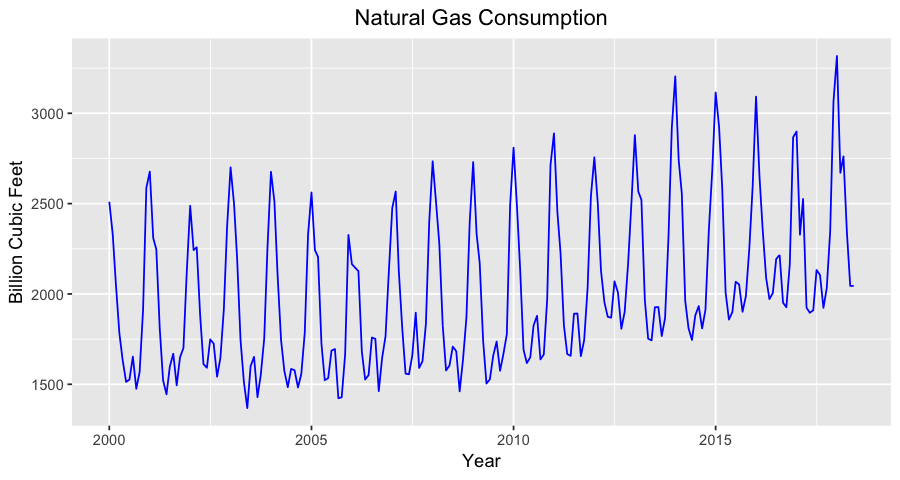

In [9]:
ggplot(data=data_df, aes(x=date)) +
    geom_line(aes(y=value), colour='blue') +
    xlab('Year') + ylab(sereis_unit) +
    ggtitle(series_title) + 
    theme(plot.title=element_text(hjust=0.5))

In [10]:
start_date <- data_df$date[1]
ts_data_df <- ts(data_df$log_value, start=c(year(start_date), month(start_date)), frequency=12)

# Package "seas"

## X11 decomposition
X11 decomposition  
https://otexts.org/fpp2/x11.html

In [17]:
x11_fit <- seas(ts_data_df, x11='', estimate.maxiter = 3000)

### X11 five best ARIMA models

In [18]:
fivebestmdl(x11_fit)

arima,bic
(2 0 1)(0 1 1),-7.151
(1 0 2)(0 1 1),-7.141
(2 0 2)(0 1 1),-7.129
(1 0 1)(0 1 1),-7.093
(1 0 0)(0 1 1),-7.089


### X11 decomposition

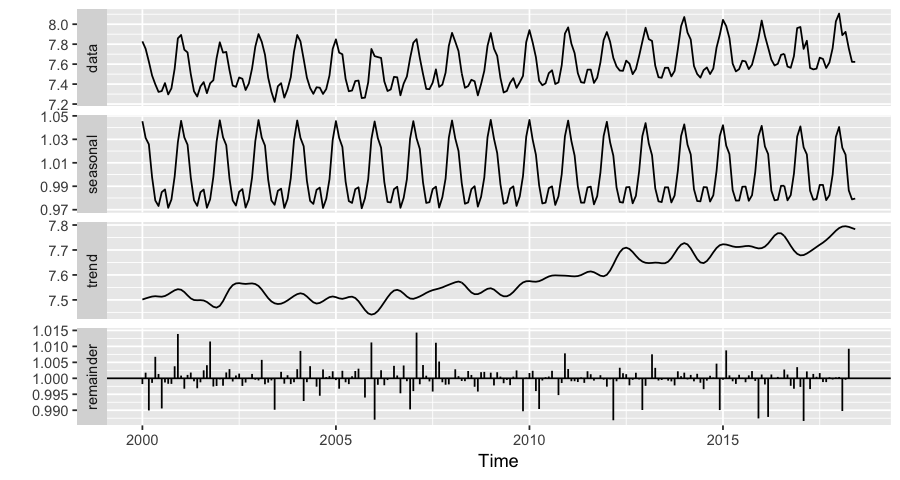

In [19]:
autoplot(x11_fit)

Import X-13ARIMA-SEATS Output Tables  
https://www.rdocumentation.org/packages/seasonal/versions/1.6.1/topics/series

specs have been added to the model: forecast


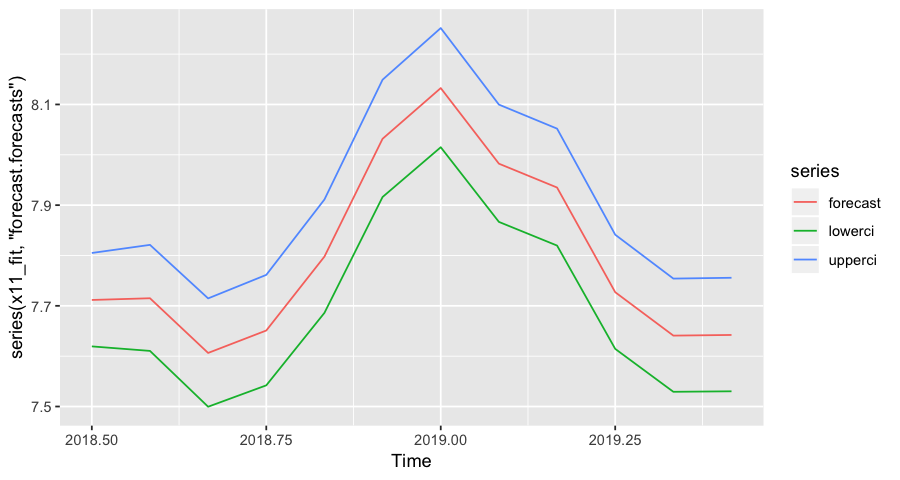

In [20]:
autoplot(series(x11_fit, "forecast.forecasts"))

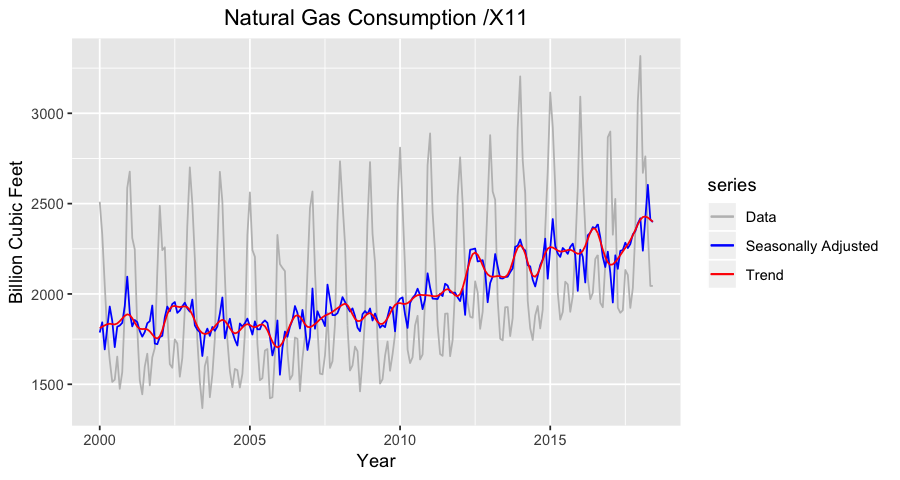

In [39]:
autoplot(exp(ts_data_df), series="Data") +
    autolayer(exp(seasadj(x11_fit)), series="Seasonally Adjusted") +
    autolayer(exp(trend(x11_fit)), series="Trend") +
    ggtitle(paste(series_title, "/X11")) +
    xlab("Year") + ylab(sereis_unit) +
    scale_colour_manual(values=c("gray", "blue", "red")) +
    theme(plot.title=element_text(hjust=0.5))


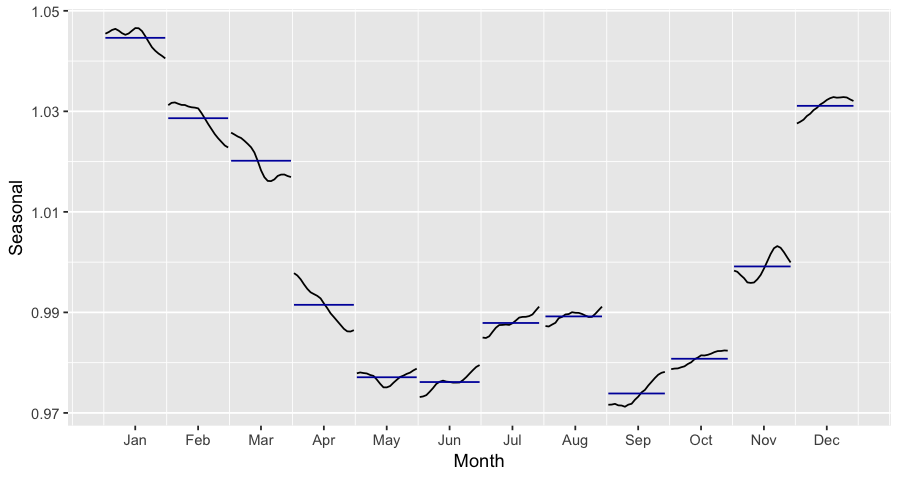

In [22]:
x11_fit %>% seasonal() %>% ggsubseriesplot() + ylab("Seasonal")

## SEATS decomposition

SEATS decomposition  
https://otexts.org/fpp2/seats.html

In [24]:
seats_fit <- seas(ts_data_df, estimate.maxiter = 3000)

### SESTS five best ARIMA models

In [25]:
fivebestmdl(seats_fit)

arima,bic
(2 0 1)(0 1 1),-7.151
(1 0 2)(0 1 1),-7.141
(2 0 2)(0 1 1),-7.129
(1 0 1)(0 1 1),-7.093
(1 0 0)(0 1 1),-7.089


### SEATS decomposition

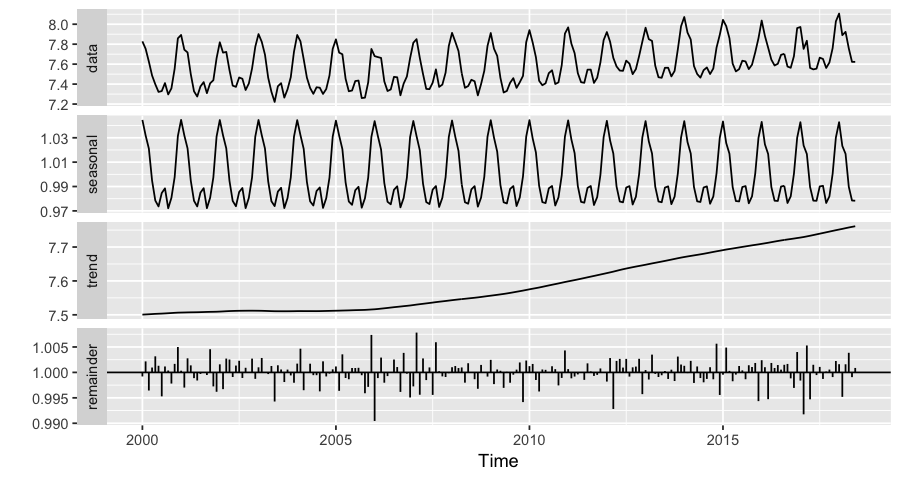

In [26]:
autoplot(seats_fit)

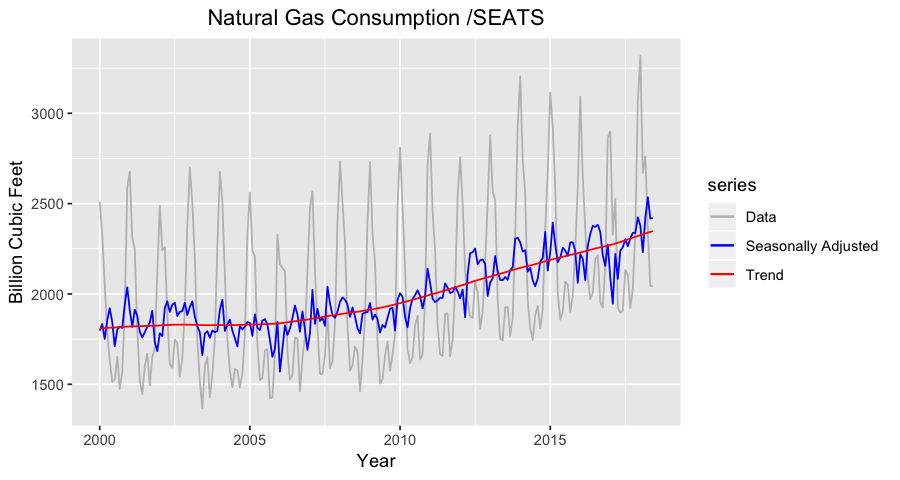

In [40]:
autoplot(exp(ts_data_df), series="Data") +
    autolayer(exp(seasadj(seats_fit)), series="Seasonally Adjusted") +
    autolayer(exp(trend(seats_fit)), series="Trend") +
    ggtitle(paste(series_title, "/SEATS")) +
    xlab("Year") + ylab(sereis_unit) +
    scale_colour_manual(values=c("gray", "blue", "red")) +
    theme(plot.title=element_text(hjust=0.5))

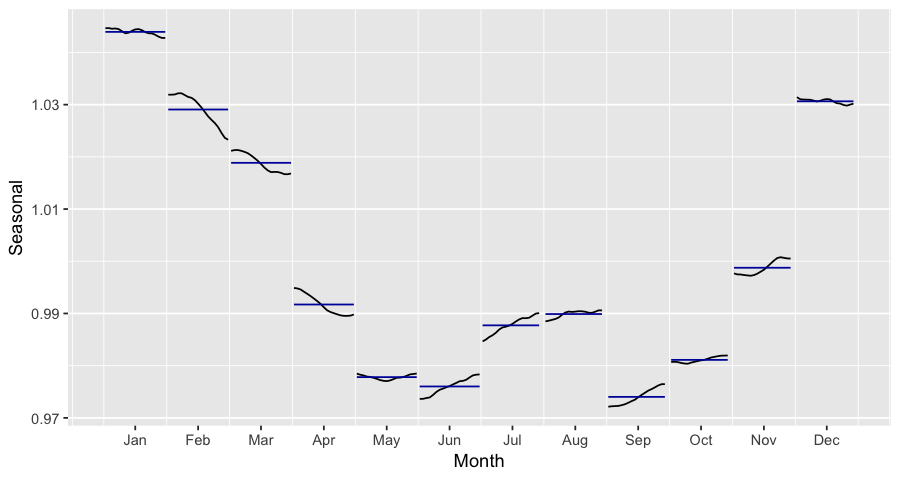

In [41]:
seats_fit %>% seasonal() %>% ggsubseriesplot() + ylab("Seasonal")

# Package "bsts"
## Bayesian structural time series model

Bayesian Structural Time Series  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/bsts  
Sorry ARIMA, but I’m Going Bayesian  
https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/  
A quick intro to bsts  
https://rstudio-pubs-static.s3.amazonaws.com/257314_131e2c97e7e249448ca32e555c9247c6.html

add.local.linear.trend  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/add.local.linear.trend  
add.seasonal  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/add.seasonal



In [73]:
## bsts model
bsts_ss <- AddLocalLinearTrend(list(), ts_data_df)
bsts_ss <- AddSeasonal(bsts_ss, ts_data_df, nseasons=12)
bsts.model <- bsts(ts_data_df, state.specification = bsts_ss, niter = 3000, ping=0)

### decomposition

In [74]:
burn <- SuggestBurn(0.1, bsts.model)

In [75]:
# extract the components
components <- cbind.data.frame(
    data=data_df$log_value,
    seasonal=colMeans(bsts.model$state.contributions[-(1:burn),"seasonal.12.1",]),
    trend=colMeans(bsts.model$state.contributions[-(1:burn),"trend",]),                               
    as.Date(time(ts_data_df)))
components$remainder <- components$data - components$seasonal - components$trend
names(components) <- c('data', 'seasonal', 'trend', 'date', 'remainder')
components <- melt(components, id="date")
names(components) <- c("date", "component", "value")

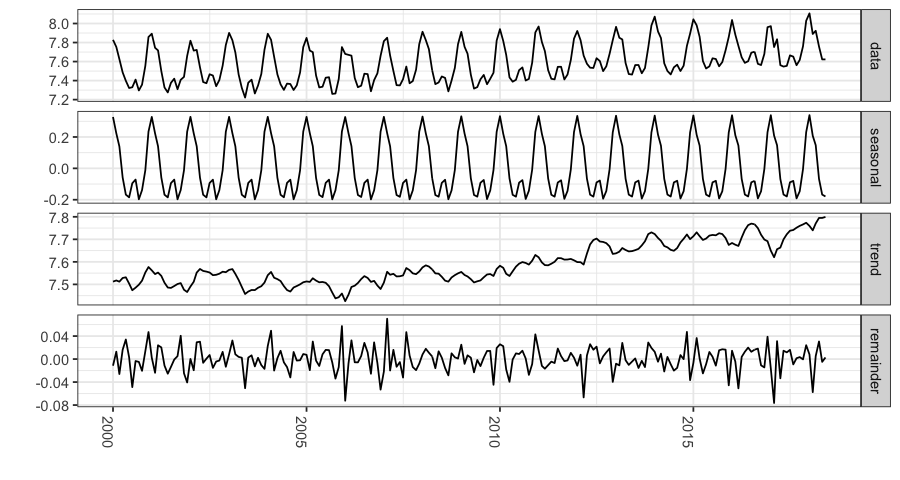

In [76]:
ggplot(data=components, aes(x=date, y=value)) +
    geom_line() + 
    theme_bw() + 
    theme(legend.title = element_blank()) + 
    ylab("") + xlab("") + 
    facet_grid(component ~ ., scales="free") + guides(colour=FALSE) + 
    theme(axis.text.x=element_text(angle = -90, hjust = 0))

### Prediction
Prediction For Bayesian Structural Time Series  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/predict.bsts

In [77]:
bsts_predict <- predict.bsts(bsts.model, horizon=12, burn=burn, quantiles=c(.025, .975))

In [78]:
# fitted values and predictions
bsts_fitted_predictions <- c(ts_data_df-colMeans(bsts.model$one.step.prediction.errors[-(1:burn),]),
                             bsts_predict$mean)
bsts_dates <- seq(data_df$date[1], by="month", length.out=length(bsts_fitted_predictions))
bsts_df <- data.frame(
    bsts_fitted_predictions,
    bsts_dates
    )
# bsts_fitted_predictions

In [79]:
bsts_df

bsts_fitted_predictions,bsts_dates
7.828237,2000-01-01
7.827312,2000-02-01
7.815025,2000-03-01
7.589796,2000-04-01
7.427352,2000-05-01
7.310641,2000-06-01
7.216971,2000-07-01
7.178430,2000-08-01
7.200973,2000-09-01
7.171089,2000-10-01


In [80]:
# actual vs predicted
bsts_predict

$mean
 [1] 7.709970 7.723084 7.613741 7.660123 7.800976 8.040331 8.148592 8.018931
 [9] 7.961451 7.747435 7.648765 7.638782

$median
 [1] 7.709797 7.723927 7.612094 7.658337 7.798297 8.040888 8.151381 8.019834
 [9] 7.960744 7.747333 7.651890 7.634718

$interval
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
2.5%  7.614594 7.610750 7.487484 7.518104 7.639185 7.879124 7.965940 7.818341
97.5% 7.813264 7.838469 7.746644 7.803539 7.960131 8.211146 8.327134 8.217386
          [,9]    [,10]    [,11]    [,12]
2.5%  7.753866 7.529197 7.427262 7.420312
97.5% 8.167223 7.957039 7.872222 7.865553

$distribution
            [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
   [1,] 7.754591 7.727026 7.724970 7.695674 7.788818 8.084675 8.148609 8.010546
   [2,] 7.710392 7.671186 7.552127 7.630261 7.725151 7.997621 8.148060 8.001695
   [3,] 7.686567 7.739147 7.578102 7.716729 7.814539 7.999536 8.141228 8.001517
   [4,] 7.705665 7.688905 7.638565 7.589852